# Functions and Interface design

This chapter presents a case study that demonstrates a process for designing functions that work together.

It introduces the `matplotlib` library, which allows us to create visual representations of data. While standard Python allows us to calculate numbers, `matplotlib` allows us to visualize them as spatial shapes.

This is our first step into the **Vector Data Model** used in GIS. In the vector model, features like buildings, roads, and boundaries are represented as:
* **Points**: Single (x, y) coordinate pairs.
* **Lines**: A sequence of connected points.
* **Polygons**: A closed sequence of lines (where the start and end points are the same).

In this chapter, we will write functions to calculate these coordinates and draw them, moving from simple squares to complex polygons.

## The Matplotlib Module

To use `matplotlib`, we need to import it. We also need the `math` module to calculate coordinates (using sine and cosine) based on angles.

In [55]:
import matplotlib.pyplot as plt
import math

Using `matplotlib` is straightforward. We provide it with two lists: one for the X coordinates and one for the Y coordinates.

Here is how we can draw a simple line segment from point (0, 0) to point (100, 100).

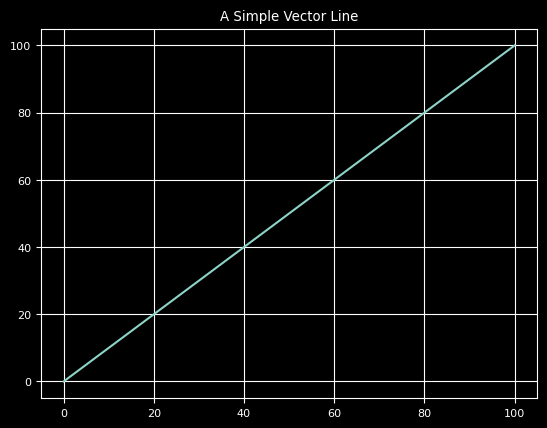

In [56]:
# Define the coordinates
x_coords = [0, 100]
y_coords = [0, 100]

# Plot the line
plt.plot(x_coords, y_coords)

# Add a title and grid for context
plt.title("A Simple Vector Line")
plt.grid(True)
plt.show()

## Simple Repetition

In GIS, a polygon is just a list of points where the first and last point are the same. 

To draw a square, we could manually list the four corners: `(0,0)`, `(100, 0)`, `(100, 100)`, `(0, 100)`, and back to `(0,0)`.

However, we can also calculate these points using a loop. This mimics how a surveyor might measure a boundary: "Walk 100 meters, turn 90 degrees left, repeat."

We can write a loop that calculates the new `x` and `y` coordinates using basic trigonometry (`math.cos` and `math.sin`) and plots a line to the new point.

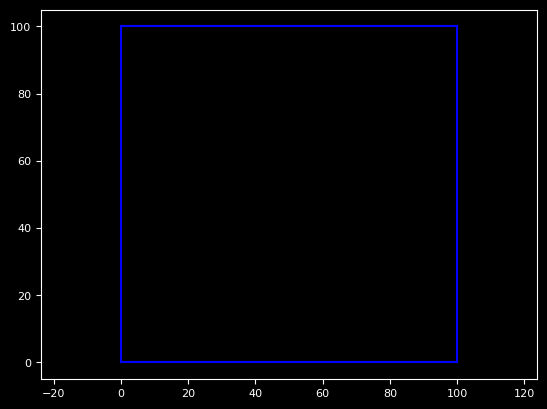

In [57]:
x = 0
y = 0
angle = 0
length = 100

for i in range(4):
    # Calculate the new position based on current angle
    # Note: math.cos takes radians, so we convert degrees to radians
    new_x = x + length * math.cos(math.radians(angle))
    new_y = y + length * math.sin(math.radians(angle))
    
    # Draw a line segment from the old position to the new position
    plt.plot([x, new_x], [y, new_y], 'b-') # 'b-' means blue line
    
    # Update our current position
    x = new_x
    y = new_y
    
    # Turn 90 degrees to the left
    angle += 90

plt.axis('equal') # Ensure the square looks like a square, not a rectangle
plt.show()

The syntax `range(4)` creates a sequence of four numbers: 0, 1, 2, and 3. The loop runs the code body four times, once for each side of the square.

This concept—calculating the next vertex based on a direction and distance—is fundamental to how vector data is created from survey measurements.

## Encapsulation

The first exercise asks you to put your square-drawing code into a function definition and then call the function, passing a parameter for the `length` of the side.

This is called **encapsulation**. It allows us to reuse the "square" logic to draw squares of any size without rewriting the coordinate math every time.

In [58]:
def square(length):
    x, y = 0, 0
    angle = 0
    
    for i in range(4):
        new_x = x + length * math.cos(math.radians(angle))
        new_y = y + length * math.sin(math.radians(angle))
        
        plt.plot([x, new_x], [y, new_y], 'b-')
        
        x, y = new_x, new_y
        angle += 90
        
    plt.axis('equal')
    plt.show()

When you define a function, it doesn't run immediately. You have to call it:

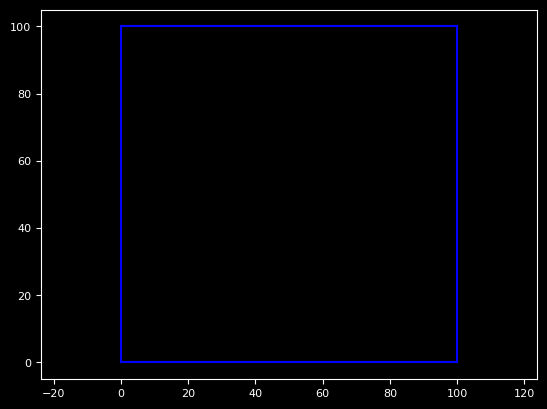

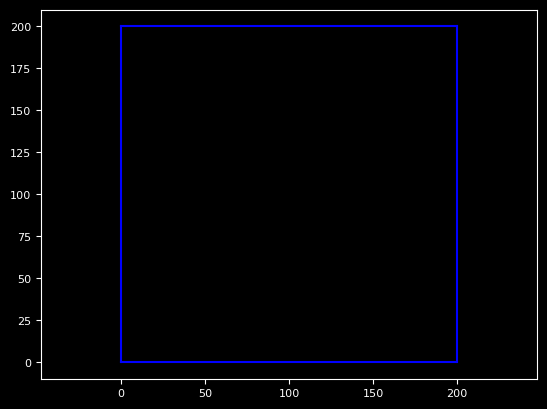

In [59]:
square(100)
square(200)

## Generalization

The next step is to add a `n` parameter to the function so it can draw regular polygons with any number of sides (e.g., a hexagon or octagon).

To do this, we need to generalize our angle logic. A square has 4 sides and turns 90 degrees ($360 / 4$). An $n$-sided polygon turns $360 / n$ degrees at each vertex.

In [60]:
def polygon(n, length):
    x, y = 0, 0
    angle = 0
    turn_angle = 360 / n
    
    for i in range(n):
        new_x = x + length * math.cos(math.radians(angle))
        new_y = y + length * math.sin(math.radians(angle))
        
        plt.plot([x, new_x], [y, new_y], 'r-') # 'r-' for red line
        
        x, y = new_x, new_y
        angle += turn_angle
        
    plt.axis('equal')
    plt.show()

Now we can use this single function to draw a triangle (3 sides) or an octagon (8 sides).

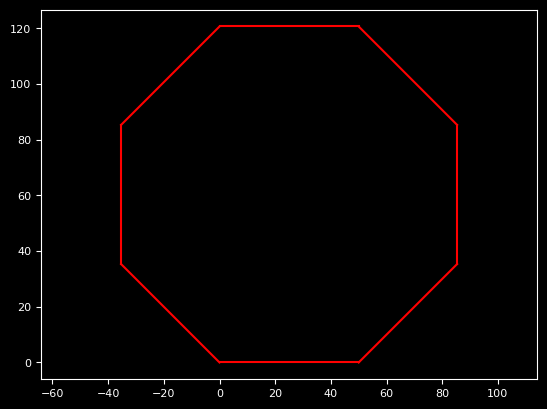

In [61]:
polygon(n=8, length=50)

This illustrates **generalization**: adding a parameter to a function to make it more general-purpose. In GIS terms, we have created a function that can generate the vector geometry for any regular building footprint or boundary.

## Interface design

The next step is to write `circle`, which takes a radius, `r`.

A computer cannot draw a true mathematical curve; it approximates curves using many short straight lines. A circle is essentially a polygon with many sides.

We can use our `polygon` function to approximate a circle.

In [62]:
def circle(r):
    circumference = 2 * math.pi * r
    n = 50
    length = circumference / n
    polygon(n, length)

This works, but the interface (the parameters) is a bit indirect. We have to compute `circumference` and `length` internally. 

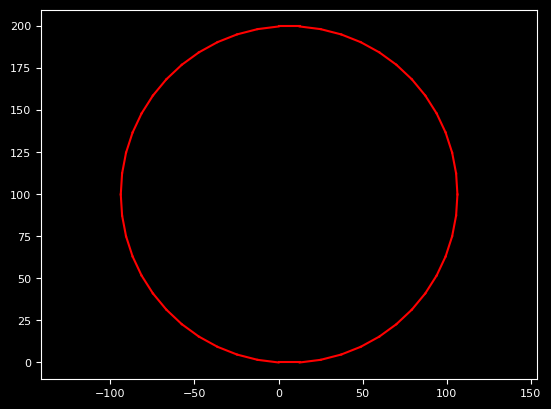

In [63]:
circle(r=100)

The **interface** of a function is a summary of how it is used: what are the parameters? What does the function do? And what is the return value? An interface is "clean" if it allows the caller to do what they want without dealing with unnecessary details.

In this example, `r` is what the caller wants to specify, but inside the function, we have to translate that into the vector data model (points and lines) using `n` and `length`.

## Refactoring

When we wrote `circle`, we used `polygon` to draw an approximation of a circle. But if we want to draw an **arc** (a portion of a circle), we can't easily use `polygon` because it always closes the shape.

A more general geometric primitive in GIS is the **polyline**—a sequence of connected lines that doesn't necessarily close.

Let's **refactor** our code. Refactoring means changing the structure of the program without changing its behavior. We will:
1. Create a `polyline` function.
2. Rewrite `polygon` to use `polyline`.
3. Use `polyline` to create `arc`.
4. Rewrite `circle` to use `arc`.

In [64]:
# 1. Create a polyline function
def polyline(n, length, angle):
    """Draws n line segments with the given length and
    angle (in degrees) between them."""
    x, y = 0, 0
    current_angle = 0
    
    for i in range(n):
        new_x = x + length * math.cos(math.radians(current_angle))
        new_y = y + length * math.sin(math.radians(current_angle))
        
        plt.plot([x, new_x], [y, new_y], 'b-')
        
        x, y = new_x, new_y
        current_angle += angle
    
    plt.axis('equal')
    plt.show()

Now we can rewrite `polygon` to use `polyline`. A polygon is just a polyline where the segments turn enough to go all the way around (360 degrees).

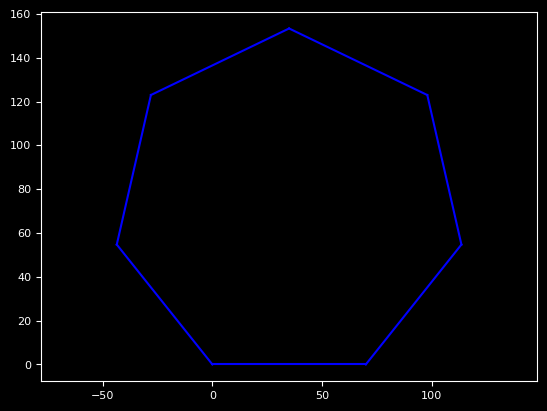

In [65]:
# 2. Rewrite polygon to use polyline
def polygon(n, length):
    angle = 360.0 / n
    polyline(n, length, angle)

polygon(7, 70)

Now we can create `arc`. An arc is just a polyline that doesn't go all the way around.

The `arc` function takes a radius `r` and an `angle` (in degrees) that determines how much of the circle to draw.

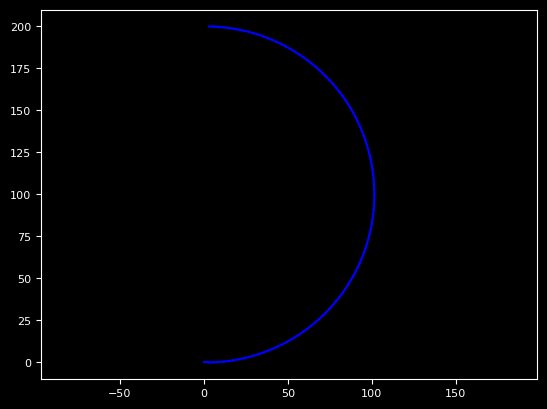

In [66]:
# 3. Use polyline to write arc
def arc(r, angle):
    arc_length = 2 * math.pi * r * angle / 360
    n = int(arc_length / 3) + 1
    step_length = arc_length / n
    step_angle = float(angle) / n
    polyline(n, step_length, step_angle)

arc(r=100, angle=180) # Draws a semicircle

Finally, we can rewrite `circle` to use `arc`. A circle is just an arc of 360 degrees.

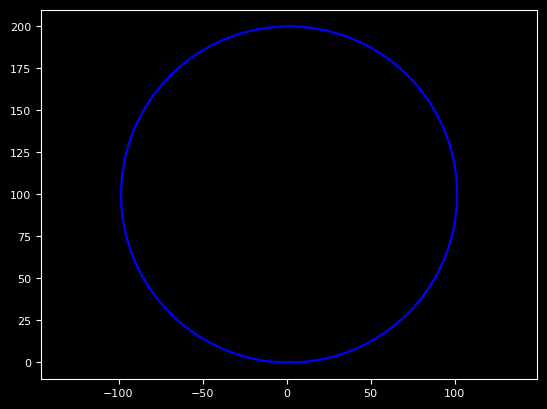

In [68]:
# 4. Rewrite circle to use arc
def circle(r):
    arc(r, 360)

circle(100)

## A development plan

A **development plan** is a process for writing programs. The process we used in this case study is "encapsulation and generalization". The steps of this process are:

1.  Start by writing a small program that has no function definitions.
2.  Once you get the program working, identify a coherent piece of it, encapsulate the piece in a function and give it a name.
3.  Generalize the function by adding parameters.
4.  Repeat steps 1–3 until you have a set of working functions. Copy and paste working code to avoid retyping (and re-debugging).
5.  Look for opportunities to improve the program by refactoring. For example, if you have similar code in several places, consider factoring it into an appropriately general function.

This process has some disadvantages—we will see alternatives later—but it can be useful if you don't know ahead of time how to divide the program into functions. This approach lets you design as you go along.

The design of a function has two parts:

* The **interface** is how the function is used, including its name, the parameters it takes and what the function is supposed to do.

* The **implementation** is how the function does what it's supposed to do.


## Docstrings

A **docstring** is a string at the beginning of a function that explains the interface ("doc" is short for "documentation").
Here is an example (same as the one above):

In [75]:
# 1. Create a polyline function
def polyline(n, length, angle):
    """Draws n line segments with the given length and
    angle (in degrees) between them."""
    x, y = 0, 0
    current_angle = 0
    
    for i in range(n):
        new_x = x + length * math.cos(math.radians(current_angle))
        new_y = y + length * math.sin(math.radians(current_angle))
        
        plt.plot([x, new_x], [y, new_y], 'b-')
        
        x, y = new_x, new_y
        current_angle += angle
    
    plt.axis('equal')
    plt.show()

By convention, docstrings are triple-quoted strings, also known as **multiline strings** because the triple quotes allow the string to span more than one line.

A docstring should:

* Explain concisely what the function does, without getting into the details of how it works,

* Explain what effect each parameter has on the behavior of the function, and

* Indicate what type each parameter should be, if it is not obvious.

Writing this kind of documentation is an important part of interface design.
A well-designed interface should be simple to explain; if you have a hard time explaining one of your functions, maybe the interface could be improved.

## Debugging

An interface is like a contract between a function and a caller. The
caller agrees to provide certain arguments and the function agrees to
do certain work.

For example, `polyline` requires three arguments: `n` has to be an integer; `length` should be a positive number; and `angle` has to be a number, which is understood to be in degrees.

These requirements are called **preconditions** because they are supposed to be true before the function starts executing. Conversely, conditions at the end of the function are **postconditions**.
Postconditions include the intended effect of the function (like drawing line segments) and any side effects (like moving the turtle or making other changes).

Preconditions are the responsibility of the caller. If the caller violates a precondition and the function doesn't work correctly, the bug is in the caller, not the function.

If the preconditions are satisfied and the postconditions are not, the bug is in the function. If your pre- and postconditions are clear, they can help with debugging.

## Glossary

**interface design:**
A process for designing the interface of a function, which includes the parameters it should take.

**canvas:**
A window used to display graphical elements including lines, circles, rectangles, and other shapes.

**encapsulation:**
 The process of transforming a sequence of statements into a function definition.

**generalization:**
 The process of replacing something unnecessarily specific (like a number) with something appropriately general (like a variable or parameter).

**keyword argument:**
An argument that includes the name of the parameter.

**refactoring:**
 The process of modifying a working program to improve function interfaces and other qualities of the code.

**development plan:**
A process for writing programs.

**docstring:**
 A string that appears at the top of a function definition to document the function's interface.

**multiline string:**
A string enclosed in triple quotes that can span more than one line of a program.

**precondition:**
 A requirement that should be satisfied by the caller before a function starts.

**postcondition:**
 A requirement that should be satisfied by the function before it ends.

### Exercise: Rectangle

Write a function called `rectangle` that takes `width` and `height` as parameters and draws a rectangle.

*Hint:* A rectangle is just a sequence of lines and 90-degree turns, but unlike a square, the side lengths alternate.

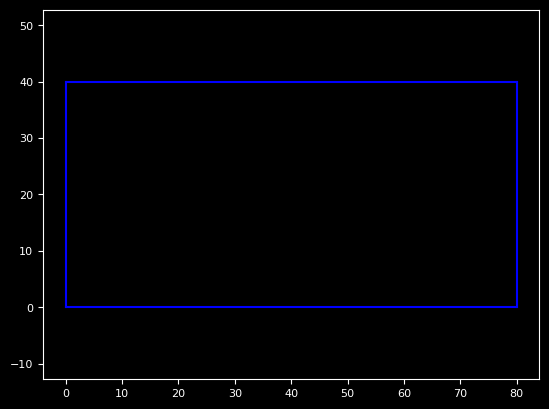

In [82]:
def rectangle(width, height):
"""Draws a rectangle with the given width and height.
    It does this by drawing the width side, turning, drawing the height side,
    turning, and repeating that process once more.
    """

    ## Put more code here.
        
    plt.axis('equal')
    plt.show()

rectangle(80, 40)

### Exercise: Search Pattern (Spiral)

Search-and-rescue operations often use an "expanding square" flight path to systematically cover an area starting from a known point.

Write a function called `search_pattern` that draws an expanding spiral. It should take `n` (number of segments), `length` (starting length), and `step` (how much the length increases each time).

*Hint:* You cannot simply call `polyline` repeatedly here, because `polyline` resets the starting point to (0,0) every time you call it. Instead, you should **copy and paste** the loop logic from your earlier functions and modify it so that the `length` variable increases by `step` inside the loop.

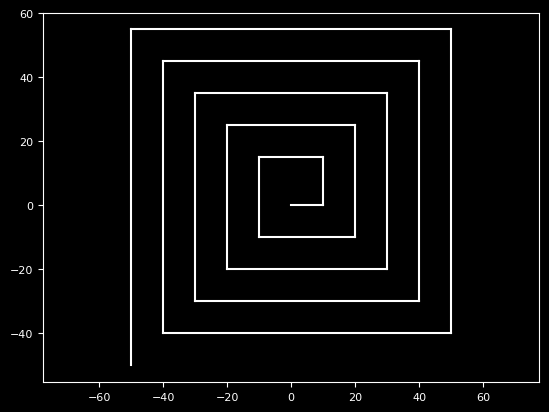

In [87]:
def search_pattern(n, length, step):
    """Draws an expanding square spiral."""

    #Write code here to complete

    plt.axis('equal')
    plt.show()

# Test the function
search_pattern(20, 10, 5)